# Replacing nested loops with function closure: application to random search

The goal of this article is to give the reader a basic understanding of Python function closures and a non-trivial example applied the removal of nested for loops `for` loops:

In [ ]:
# Replace a nested for loop like this one:
for i in range(10):
    for k in range(5):
        for l in range(20):
            for z in ['mean','median','min','max']:
                #do something with i,k,l,zip

# With a function closure (get_grid) representation such as:
M,ind2params=get_grid({'i':range(10),'k':range(5),'l':range(20),'z':['mean','median','min','max']})
for m in range(M):
    params=ind2params(m)
    #do something with params['i'],params['k'],params['l'],params['z']

Some key advantages of the use of function closures instead of nested loops include:
* Improved extendability and maintainability ( easier to add more `for` loop conditions without having to indent code)
* Improved readability
* Easy tracking of progress, by simply tracking only one index `m` user can interrupt and restart progress of at desired `m`
* The closure can be modified to include caching to avoid repeated runs.
* Easy to modify for a random order

While there excellent tools for machine learning hyper-parameter optimization such as
[scikit-learn pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) and [optuna](https://optuna.org/), the method described here can still be useful in cases such as:

* You wish to extend the hyper-parameter search to pre-processing steps such as: cohort exclusion criterias, the hyper-parameters of your own pipeline (ie: number of optuna trials, scikit-learn model types, etc), feature selection parameters.
* You are using a framework or legacy code that is not easily modifiable to fit scikit-learn pipeline and your hyper parameter optmization of choice.
* Your number of parameters is small and on a high-dimensional space and you would like to quickly explore the space with python standard libraries.

Note: The grid and random approaches described in this tutorial are not recommend for large parameter spaces, in which case Bayesian search approaches such are those provided by Optuna are likely more efficient.

## Introduction to Python function closure

At a high level, you can think of Python function closures as function that return an internal function whose workspace ( or state) is frozen.  A classical `hello-word` example, shown below, is to create a function closure (`get_pow_by_n` below) that return an internal function (`pow_by_n`) where its internal state (`n` ) is frozen and is used in an internal function to compute the an input `x` to that power:

In [9]:
def get_pow_by_n(n):
    #Return function frozen power factor n
    def pow_by_n(x):
        return x**n
    return pow_by_n

#Creat 2 instances (functions), with different states
pow_by_2=get_pow_by_n(2)
pow_by_pi=get_pow_by_n(3.14)

#Use these the two instances to perform calculation
y=pow_by_2(2)
z=pow_by_pi(2)
print("pow_by_2(2) = %s"%y)
print("pow_by_pi(2) = %s"%z)


pow_by_2(2) = 4
pow_by_pi(2) = 8.815240927012887


## Removing nested loops with function closures

If we think of for loops as indices to a multidimensional matrix, we can apply a function closure to remove nested loops by "flattening" the index structure. So for example, two `for` loops can be thought of as a matrix, with the 2D index structures mapped to a linear (1D) index:

![title](sub2ind.png)

For those familiar with MATLAB programming language, this is similar in to the MATLAB function `sub2ind`. Thus in a similar way to the 2D case above, we can generalize the map to the case of `M` `for` loops into a M-dimensional matrix, and get its linear 1D index structure with a closure. In this case we are using a function closure return a function that has stored as it's state the list size of each `for` loop (ie: D1=M, D2=N). The returned function with its frozen states thus maps a linear index  (it's input `x`) to any cell in the hyper-cube, where each dimension represents a `for` loop, returning a dictionary representing the value for each of the `for` loop variables.

Let's look at an example with a **toy** 2D dataset from matplotlib, where we with to find the largest z value by searching through the X and Y coordinates:


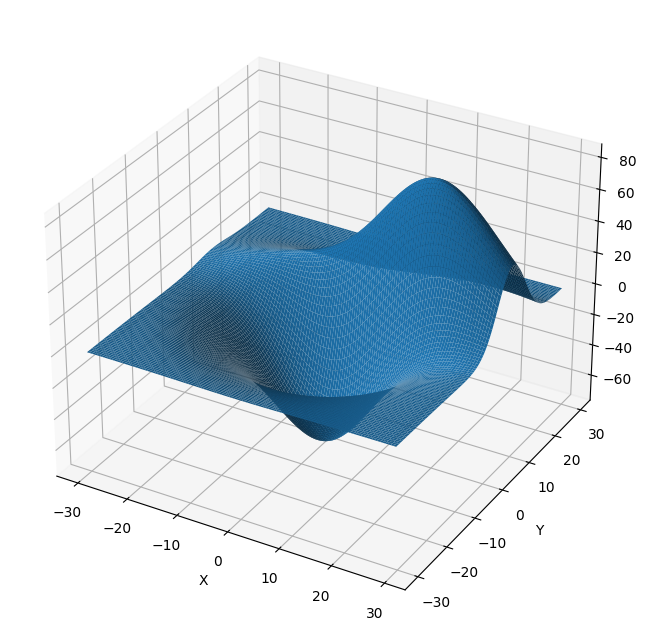

In [103]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import get_test_data
fig = plt.figure(figsize=(8, 20))
ax = fig.add_subplot(1, 1, 1, projection='3d')
X, Y, Z = get_test_data(0.05)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1)
ax.set_xlabel('X');ax.set_ylabel('Y')
plt.show()

We first start by defining our function closure below:

In [55]:
import numpy as np

def get_grid(hyper_params):
    '''
    :param hyper_params: dictionary of parameter (or loop variables) following the syntax:
                        {'var_name' :list(values}
    :return: M int: Maximum number of combinations of all elements (values in the dictionary input)
             ind2params: Function that maps an integer (m) to a set of unique parameter values for the hyper_params keys.
    '''
    def ind2params(ind):
        if ind<M:
            param_ind = np.unravel_index(ind,grid_shape)
            subind= dict(zip(param_names, param_ind))
            params={k:hyper_params[k][v] for k,v in subind.items()}
            return params
        else:
            raise Exception("Index %s outside grid range %s"%(ind,M))
    #Store number of elements per each hyperparameter, ie: Ndict={'a': 3, 'b': 3, 'c': 3}
    Ndict={k:len(v) for k, v in hyper_params.items()}
    param_names=[k for k,_ in Ndict.items()]
    grid_shape=[v for _,v in Ndict.items()]
    M=np.product(grid_shape)
    return M,ind2params

Where the key line `param_ind = np.unravel_index(ind,grid_shape)` maps the N-dimensional index structure to a linear structure. Using the closure above in a single for loop we can find the x,y coordinates that maximizes our z:

Final best value Z=84.98193133124555 parameters={'i': 81, 'j': 90}, X=10.499999999999856 Y=14.99999999999984


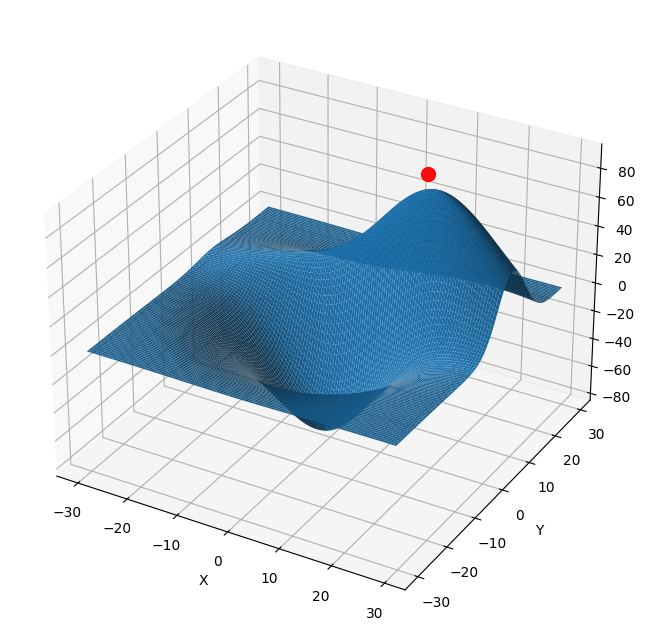

In [104]:
hyper_params={'i':range(Z.shape[0]),'j':range(Z.shape[1])}
M,ind2params=get_grid(hyper_params)
best=(None,-np.inf)

for m in range(M):
    params=ind2params(m)
    value = Z[params['i'],params['j']]
    if value>best[1]:
        best=(params,value)
print("Final best value Z=%s parameters=%s, X=%s Y=%s"%(best[1],best[0],X[0,best[0]['i']],Y[best[0]['j'],0]))


#Plot Results
fig = plt.figure(figsize=(8, 20))
ax = fig.add_subplot(1, 1, 1, projection='3d')
X, Y, Z = get_test_data(0.05)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1)
params=best[0] #get best parameters
ax.scatter(X[0,params['i']],Y[params['j'],0],best[1], c='red', marker='o', s=100,alpha=0.95)
ax.set_xlabel('X');ax.set_ylabel('Y')
plt.show()

# Applying Random Search

Random search can be applied with simple use of the `shufle` method for lists. Lets say for example, due to computational resources, you can only run your code over 30 iterations:

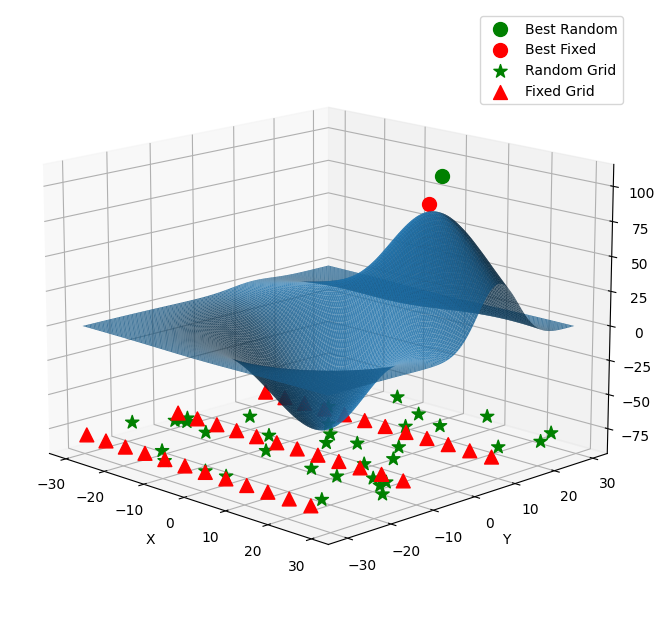

In [218]:
from random import shuffle
best_r=(None,-np.inf)
best_f=(None,-np.inf)

#Shuffle the indices to perform a random search
indices = [i for i in range(M)]
shuffle(indices)

P=36 #Number of maximum iterations you would like to do
random_tracker=[] #For plotting purposes
fixed_tracker=[] #For plotting purposes
step=int(np.floor(M/P))

for c,m in enumerate(indices[:P]):
    #Deterministic search
    params=ind2params(c*step+1)
    fixed_tracker.append([X[0,params['i']],Y[params['j'],0],-80])#Z[params['i'],params['j']]+10])
    if Z[params['i'],params['j']]>best_f[1]:
        best_f=(params,Z[params['i'],params['j']])

    #Random search
    params=ind2params(m)
    random_tracker.append([X[0,params['i']],Y[params['j'],0],-80])#value+10])
    if Z[params['i'],params['j']]>best_r[1]:
        best_r=(params,Z[params['i'],params['j']])

#Plot Results
random_tracker=np.array(random_tracker)
fixed_tracker=np.array(fixed_tracker)
fig = plt.figure(figsize=(8, 20))
ax = fig.add_subplot(1, 1, 1, projection='3d')
X, Y, Z = get_test_data(0.05)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,alpha=0.85)
ax.scatter(X[0,best_r[0]['i']],Y[best_r[0]['j'],0],best_r[1]+20, c='g', marker='o', s=100,alpha=1,label='Best Random')
ax.scatter(X[0,best_f[0]['i']],Y[best_f[0]['j'],0],best_f[1]+20, c='r', marker='o', s=100,alpha=1,label='Best Fixed')
ax.scatter(random_tracker[:,0],random_tracker[:,1],random_tracker[:,2], c='g', marker='*', s=100,alpha=1,label='Random Grid')
ax.scatter(fixed_tracker[:,0],fixed_tracker[:,1],fixed_tracker[:,2], c='r', marker='^', s=100,alpha=1,label='Fixed Grid')
ax.set_xlabel('X');ax.set_ylabel('Y')
ax.view_init(elev=15, azim=135+180)
ax.legend()
plt.show()

# Conclusion

In summary we have looked into Python function closure's and how to use them to avoid nested loop. We used a function closure to store information about the list size of each for loop, allowing us to create a 1D linear indexing that can be iterated with a single for loop instead. This function closure can  then be used to perform parameter optimization either through systematic grid search or random search iterations.

This approach allows for more readable and extensible code when compared with nested for loops.


